# Exemples d'utilisation de modèles simplifiés RC

<div style="text-align: right"> André Mounier </div>

---
Étude de l'effet sur les estimations de consommations annuelles

**Importation des modules**

In [1]:
import os 
import numpy as np
import tqdm
from datetime import date
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [2]:
today = pd.Timestamp(date.today()).strftime('%Y%m%d')

output = 'output'
folder = '{}_RC_models'.format(today)
figs_folder = os.path.join(output, folder, 'figs')

if folder not in os.listdir(output):
    os.mkdir(os.path.join(output,folder))
if 'figs' not in os.listdir(os.path.join(output, folder)):
    os.mkdir(figs_folder)

In [3]:
draw_plots = False

## Définition de la température extérieure ($T_a$)

#### Valeurs historiques

Récupération de données historiques via l'API d'[Open-Météo](https://open-meteo.com) pour des [coordonnées](https://www.gps-longitude-latitude.net/longitude-latitude-coordonnees-gps-du-lieu) données.

In [4]:
def get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables):
    """
    Récupération de l'url de l'API Open-Météo
    """
    if isinstance(hourly_variables, list):
        hourly_variables = ','.join(hourly_variables)
    url = 'https://archive-api.open-meteo.com/v1/archive?latitude={}&longitude={}&start_date={}-01-01&end_date={}-12-31&hourly={}&timezone=Europe%2FBerlin'.format(latitude,longitude,start_year,end_year,hourly_variables)
    return url


def open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables, force=False):
    """
    Ouverture des fichiers meteo
    """
    if isinstance(hourly_variables, list):
        hourly_variables_str = ','.join(hourly_variables)
    else:
        hourly_variables_str = hourly_variables
        
    save_path = os.path.join('data','Open-Meteo')
    save_name = '{}_{}_{}_{}_{}.csv'.format(hourly_variables_str, start_year, end_year, longitude, latitude)
    save_name_units = '{}_{}_{}_{}_{}_units.txt'.format(hourly_variables_str, start_year, end_year, longitude, latitude)

    if save_name not in os.listdir(save_path) or force:
        url = get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables)
        response = requests.get(url)
        json_data = response.json()

        units = json_data.get('hourly_units')
        with open(os.path.join(save_path,save_name_units), 'w') as f:
            for col, unit in units.items():
                f.write('{} : {} \n'.format(col,unit))
        
        data = pd.DataFrame().from_dict(json_data.get('hourly'))
        data.to_csv(os.path.join(save_path,save_name), index=False)
        
    data = pd.read_csv(os.path.join(save_path,save_name))
    data = data.set_index('time')
    data.index = pd.to_datetime(data.index)
    return data

In [5]:
coordinates_dict = {'Paris':(2.352222, 48.856614),
                    'Marseille':(5.369780, 43.296482)
                   }

In [6]:
longitude, latitude = coordinates_dict.get('Marseille')
start_year, end_year = 2000, 2020
hourly_variables = 'temperature_2m'

In [7]:
temperature_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables)
temperature_data.head()

,temperature_2m
time,
2000-01-01 00:00:00,0.9
2000-01-01 01:00:00,0.6
2000-01-01 02:00:00,0.4
2000-01-01 03:00:00,0.1
2000-01-01 04:00:00,-0.1


#### Approximations sinusoïdales

La température extérieure peut être vue comme constante sommée à une double sinusoïdale, d'une période journalière et annuelle :
$$
T_a(t) = \mu_y + \delta_y \sin\left(\frac{2\pi}{T_y}t + \phi_y \right) + \delta_d \sin\left(\frac{2\pi}{T_d}t + \phi_d \right)
$$
On utilise les données historiques pour obtenir les différents paramètres.
**C'est faux pour les variations journalières, à modifier**

In [8]:
month_day_hourly_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
month_day_hourly_data.index = month_day_hourly_data.index.strftime('%Y-%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    temperature_data_year = temperature_data[temperature_data.index.year==y]
    temperature_data_year = temperature_data_year.rename(columns={'temperature_2m':y})
    temperature_data_year.index = temperature_data_year.index.strftime('2000-%m-%d %H:%M:%S')
    
    month_day_hourly_data = month_day_hourly_data.join(temperature_data_year,how='left')
month_day_hourly_data.index = [pd.to_datetime('{}'.format(t)) for t in month_day_hourly_data.index]
month_day_hourly_data.index = month_day_hourly_data.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
month_day_hourly_data = month_day_hourly_data[month_day_hourly_data.index.year==2000]
month_day_hourly_data.head()

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 49.58it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00+01:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,6.6,10.9,8.9,8.7,4.9,10.5,3.7,12.3,5.0,6.7
2000-01-01 01:00:00+01:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,6.1,10.7,8.7,8.2,5.1,10.3,3.5,11.8,8.0,5.8
2000-01-01 02:00:00+01:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,6.0,10.5,9.0,8.2,5.1,10.0,6.9,11.2,10.3,7.3
2000-01-01 03:00:00+01:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,5.8,10.2,9.3,7.8,4.7,9.9,6.2,11.2,11.0,5.2
2000-01-01 04:00:00+01:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,5.8,10.0,9.6,7.4,4.6,9.6,5.4,10.8,9.0,5.3


En commençant par l'amplitude annuelle.

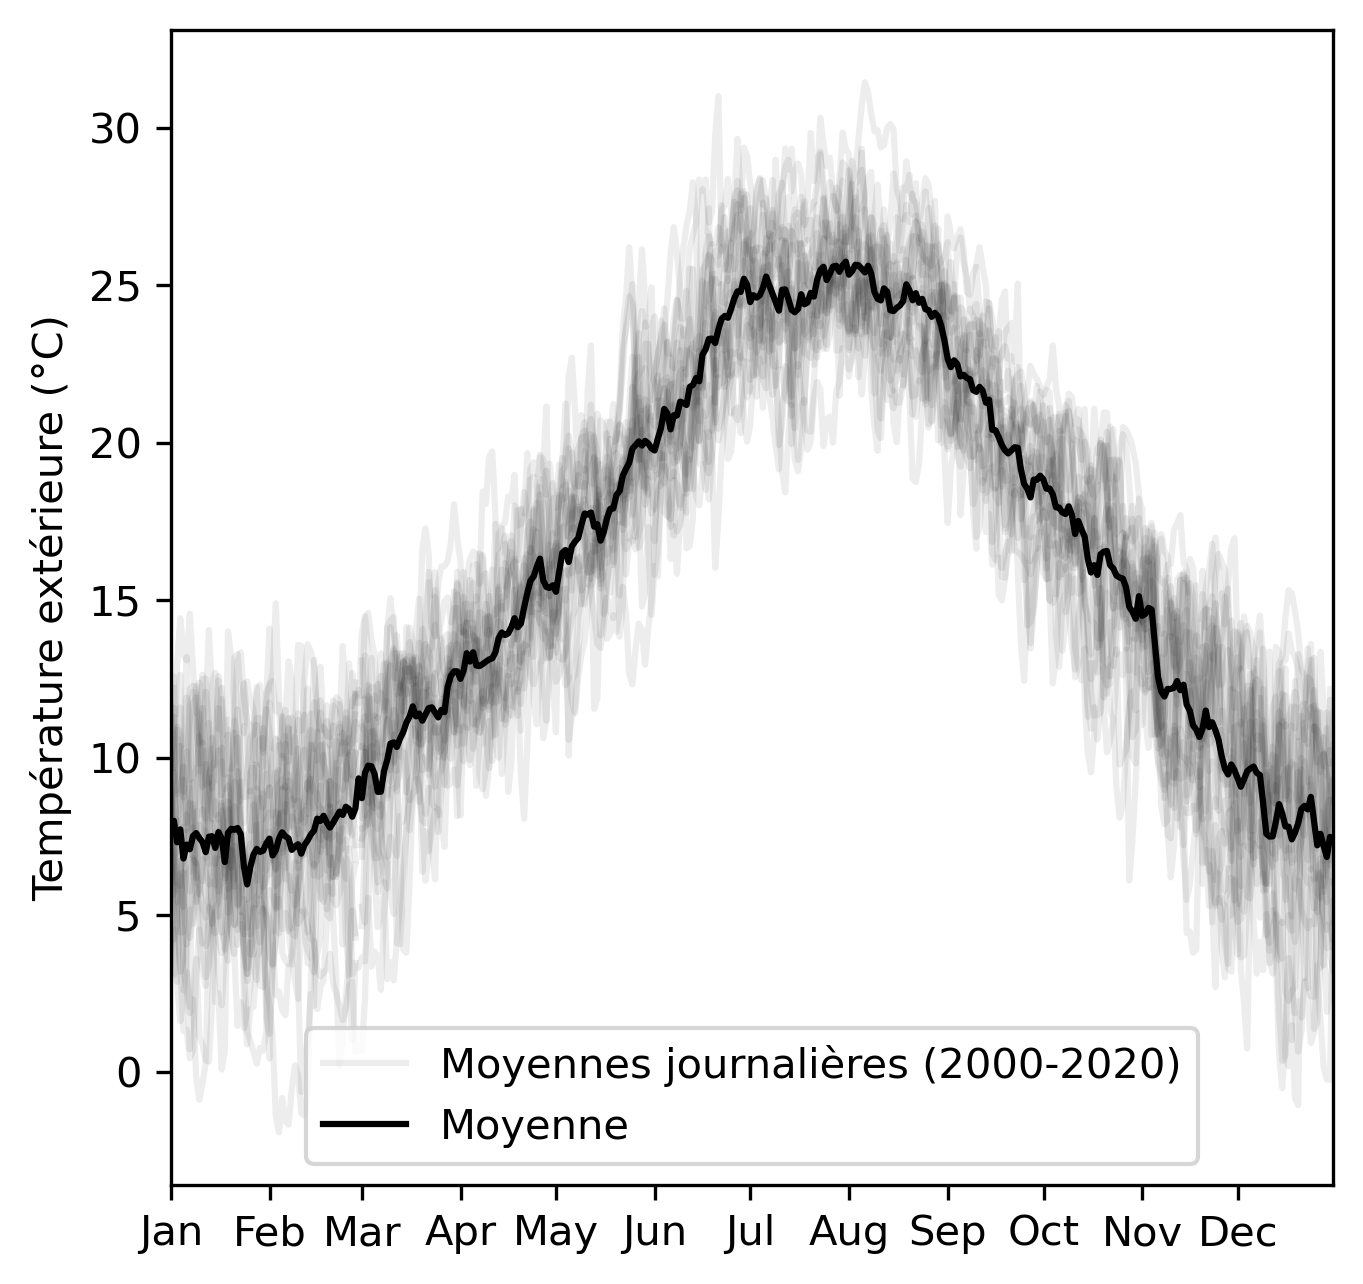

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 455.48it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature
2000-01-01 00:00:00+01:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,10.9,8.9,8.7,4.9,10.5,3.7,12.3,5.0,6.7,7.590450
2000-01-01 01:00:00+01:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,10.7,8.7,8.2,5.1,10.3,3.5,11.8,8.0,5.8,7.587861
2000-01-01 02:00:00+01:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,10.5,9.0,8.2,5.1,10.0,6.9,11.2,10.3,7.3,7.585277
2000-01-01 03:00:00+01:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,10.2,9.3,7.8,4.7,9.9,6.2,11.2,11.0,5.2,7.582697
2000-01-01 04:00:00+01:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,10.0,9.6,7.4,4.6,9.6,5.4,10.8,9.0,5.3,7.580122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00+01:00,5.0,4.1,10.7,4.9,6.4,8.4,11.0,6.2,9.2,11.2,...,10.4,10.0,5.8,12.2,8.6,12.3,9.4,9.4,7.9,7.542023
2000-12-31 20:00:00+01:00,3.4,3.2,10.0,4.3,5.6,7.9,11.1,5.1,9.0,10.5,...,9.7,9.4,5.1,11.7,6.7,12.4,8.7,9.2,9.5,7.539519
2000-12-31 21:00:00+01:00,4.5,3.2,10.1,3.8,5.2,9.2,9.3,4.3,9.8,10.3,...,9.3,9.4,4.7,11.4,5.4,12.8,8.0,8.1,10.2,7.537019
2000-12-31 22:00:00+01:00,4.1,2.7,9.8,3.7,4.4,8.7,7.8,3.4,9.8,10.0,...,9.0,9.2,4.5,11.1,4.6,12.8,7.3,8.0,9.8,7.534523


In [9]:
if True:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Moyennes journalières ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_timeserie.png'),bbox_inches='tight')
    plt.show()

def annual_temperature_variation(t,mu_y=20, delta_y=10, phi_y=0):
    """
    Variations de températures annuelles au pas de temps horaire
    """
    t_hour = (t- t[0]).days*24 + (t- t[0]).seconds/3600
    T_hour = 24*365
    
    temperature = mu_y + delta_y * np.sin(2*np.pi*t_hour/T_hour+phi_y)
    return temperature

# on utilise les miyennes journalières et non pas horaires (réduction du bruit)
month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()

# moyenne des 20 années de données (2000-2020)
mean_daily = month_day_daily_data[years].mean(axis=1)

# moyenne glissante sur 10 jours pour lisser le fit de la sinusoide
mean_daily = mean_daily.rolling(10,center=True).mean()

# défintion des paramètres de la sinusoidale annuelle 
mu_y = (mean_daily.max() + mean_daily.min())/2
delta_y = mean_daily.max() - mu_y

shift_list = np.linspace(0,2*np.pi,100)
corr_list = []
for shift in tqdm.tqdm(shift_list):
    month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=shift)

    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    corr_list.append(corr)
phi_y = shift_list[corr_list.index(max(corr_list))]

# calcul des variations de températures annuelles
month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=phi_y)

if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(shift_list,corr_list,label='Corrélation max : {:.1f} rad'.format(phi_y))
    ax.set_xlabel('Déphasage (rad)')
    ax.set_ylabel('Corrélation (R$^2$)')
    ax.legend()
    ax.set_ylim([0,1])
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_corr.png'),bbox_inches='tight')
    plt.show()

if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    label= 'R$^2$ = {:.2f}'.format(corr)
    ax.plot(month_day_daily_data['model_annual_temperature'],month_day_daily_data[years].mean(axis=1),color='k',ls='',marker='o',alpha=0.05,label=label)
    ax.legend()
    ax.set_xlabel('Température extérieure modélisée (°C)')
    ax.set_ylabel('Température extérieure observée (°C)')
    diag = [0,month_day_hourly_data.max().max()]
    ax.plot(diag,diag, color='k')
    ax.set_ylim(diag)
    ax.set_xlim(diag)
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_versus.png'),bbox_inches='tight')
    plt.show()
    
if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(month_day_daily_data[years].mean(axis=1),label='Observations (moyenne journalière)',color='k')
    ax.fill_between(month_day_daily_data[years].index, 
                    month_day_daily_data[years].mean(axis=1)+month_day_daily_data[years].std(axis=1),
                    month_day_daily_data[years].mean(axis=1)-month_day_daily_data[years].std(axis=1),color='lightgrey',zorder=-1)
    ax.plot(month_day_daily_data['model_annual_temperature'],label='Modélisation sinusoïdale',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_timeserie.png'),bbox_inches='tight')
    plt.show()

month_day_hourly_data

Modélisation des variations intrajournalières. Pour éviter d'avoir trop de journées, j'utilise uniquement l'année 2020. 

In [10]:
prep_hour_hourly_data = pd.DataFrame(month_day_hourly_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
prep_hour_hourly_data['hour'] = prep_hour_hourly_data.index.hour
prep_hour_hourly_data['month'] = prep_hour_hourly_data.index.month
hour_hourly_data = prep_hour_hourly_data.groupby(['month','hour']).mean()
hour_hourly_data = hour_hourly_data.reset_index()

def get_second_order_daily_temperature_parameters(data):
    """
    Obtention des paramètres de modélisation des variations de températures journalières.
    """
    t = data.index.values
    res = np.zeros(t.shape)

    K_day = data.mean_value.max()
    K_night = data.mean_value.min()

    warming_period_start_hour = data.mean_value.idxmin()%24
    cooling_period_start_hour = data.mean_value.idxmax()%24
    tau = (cooling_period_start_hour - warming_period_start_hour)/4.5
    
    warming_period = (t%24>=warming_period_start_hour)&(t%24<=cooling_period_start_hour)
    cooling_period = (t%24>=cooling_period_start_hour)|(t%24<=warming_period_start_hour)
    intersection_period = (warming_period) & (cooling_period)
    
    def temperature_warming_period(t,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        tp[tp < 0] += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    p0_warming = (K_day,K_night,tau)
    popt_warming, _ = curve_fit(temperature_warming_period, t[warming_period], data.mean_value.values[warming_period], p0=p0_warming, method='lm')
    p0_cooling = (K_day,K_night,tau)
    popt_cooling, _ = curve_fit(temperature_cooling_period, t[cooling_period], data.mean_value.values[cooling_period], p0=p0_cooling, method='lm')
    
    #res[cooling_period] = temperature_cooling_period(t[cooling_period],*popt_cooling)
    #res[warming_period] = temperature_warming_period(t[warming_period],*popt_warming)
    #res[intersection_period] = (temperature_warming_period(t[intersection_period],*popt_warming) + temperature_cooling_period(t[intersection_period],*popt_cooling))/2

    parameters = {'warming':(warming_period_start_hour,*popt_warming),
                  'cooling':(cooling_period_start_hour,*popt_cooling),
                 }
    return parameters

daily_profile_parameters = dict()
for month in range(1,13):
    plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
    plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
    more_hour = list(range(24,100))
    more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
    plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])

    params = get_second_order_daily_temperature_parameters(plot_hour_hourly_data)
    daily_profile_parameters[month] = params

daily_profile_parameters.get(1)

{'warming': (np.int64(8),
  np.float64(5.870630691722853),
  np.float64(-2.7096681646962124),
  np.float64(3.6607951343622203)),
 'cooling': (np.int64(16),
  np.float64(3.612920270549295),
  np.float64(-2.2151895012018694),
  np.float64(3.3211858161740926))}

In [11]:
def get_second_order_daily_temperature(t,parameters_dict):
    """
    Modélisation simplifiée des variations de températures journalières. 
    """
    def temperature_warming_period(t,warming_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,cooling_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        if tp < 0:
            tp += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))
        
    res = [np.nan]*len(t)
    for i,date in enumerate(t):
        date = pd.Timestamp(date)
        h = date.hour
        parameters = parameters_dict.get(date.month)
        param_warming = parameters.get('warming')
        param_cooling = parameters.get('cooling')

        warming_period = (h%24>=param_warming[0])&(h%24<=param_cooling[0])
        cooling_period = (h%24>=param_cooling[0])|(h%24<=param_warming[0])
        intersection_period = (warming_period) & (cooling_period)

        if intersection_period:
            res[i] = (temperature_warming_period(h,*param_warming) + temperature_cooling_period(h,*param_cooling))/2
        elif warming_period:
            res[i] = temperature_warming_period(h,*param_warming)
        else:
            res[i] = temperature_cooling_period(h,*param_cooling)
    return res

month_day_hourly_data['model_daily_temperature'] = get_second_order_daily_temperature(month_day_hourly_data.index.values,daily_profile_parameters)
month_day_hourly_data['model_temperature'] = month_day_hourly_data['model_annual_temperature'] + month_day_hourly_data['model_daily_temperature']
month_day_hourly_data.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature,model_daily_temperature,model_temperature
2000-01-01 00:00:00+01:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,8.7,4.9,10.5,3.7,12.3,5.0,6.7,7.590450,-0.843513,6.746937
2000-01-01 01:00:00+01:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,8.2,5.1,10.3,3.5,11.8,8.0,5.8,7.587861,-1.214132,6.373729
2000-01-01 02:00:00+01:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,8.2,5.1,10.0,6.9,11.2,10.3,7.3,7.585277,-1.465334,6.119943
2000-01-01 03:00:00+01:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,7.8,4.7,9.9,6.2,11.2,11.0,5.2,7.582697,-1.655326,5.927371
2000-01-01 04:00:00+01:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,7.4,4.6,9.6,5.4,10.8,9.0,5.3,7.580122,-1.798168,5.781953


In [12]:
if False:
    days = 1
    intervals = 6
    
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
        plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
        more_hour = list(range(24,100))
        more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
        plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])
        if month in [1,4,7,10]:#list(range(1,13)):
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour,plot_hour_hourly_data.mean_value,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            model = get_second_order_daily_temperature([pd.to_datetime('2000-{}-01 {}:00:00'.format(month, h%24)) for h in plot_hour_hourly_data.hour], daily_profile_parameters)
            corr = r2_score(plot_hour_hourly_data.mean_value, model)
            ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    ax.set_xlabel('Heure de la journée (h)')
    ax.set_ylabel('Écart à la température moyenne journalière (°C)')
    
    plt.savefig(os.path.join(figs_folder,'daily_temperature_2nd_order_fit_timeserie.png'),bbox_inches='tight')
    plt.show()

## Définition des apports solaires ($\Phi_s$)

#### Récupération des valeurs historiques

In [13]:
solar_variable = 'direct_radiation_instant' # 'direct_normal_irradiance_instant'
solar_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, solar_variable)
solar_data.head()

,direct_radiation_instant
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0


In [14]:
month_day_hourly_solar_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
month_day_hourly_solar_data.index = month_day_hourly_solar_data.index.strftime('%Y-%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    solar_data_year = solar_data[solar_data.index.year==y]
    solar_data_year = solar_data_year.rename(columns={solar_variable:y})
    solar_data_year.index = solar_data_year.index.strftime('2000-%m-%d %H:%M:%S')
    
    month_day_hourly_solar_data = month_day_hourly_solar_data.join(solar_data_year,how='left')
month_day_hourly_solar_data.index = [pd.to_datetime('{}'.format(t)) for t in month_day_hourly_solar_data.index]
month_day_hourly_solar_data.index = month_day_hourly_solar_data.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
month_day_hourly_solar_data = month_day_hourly_solar_data[month_day_hourly_solar_data.index.year==2000]
month_day_hourly_solar_data

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 51.30it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 02:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 20:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 21:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 22:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


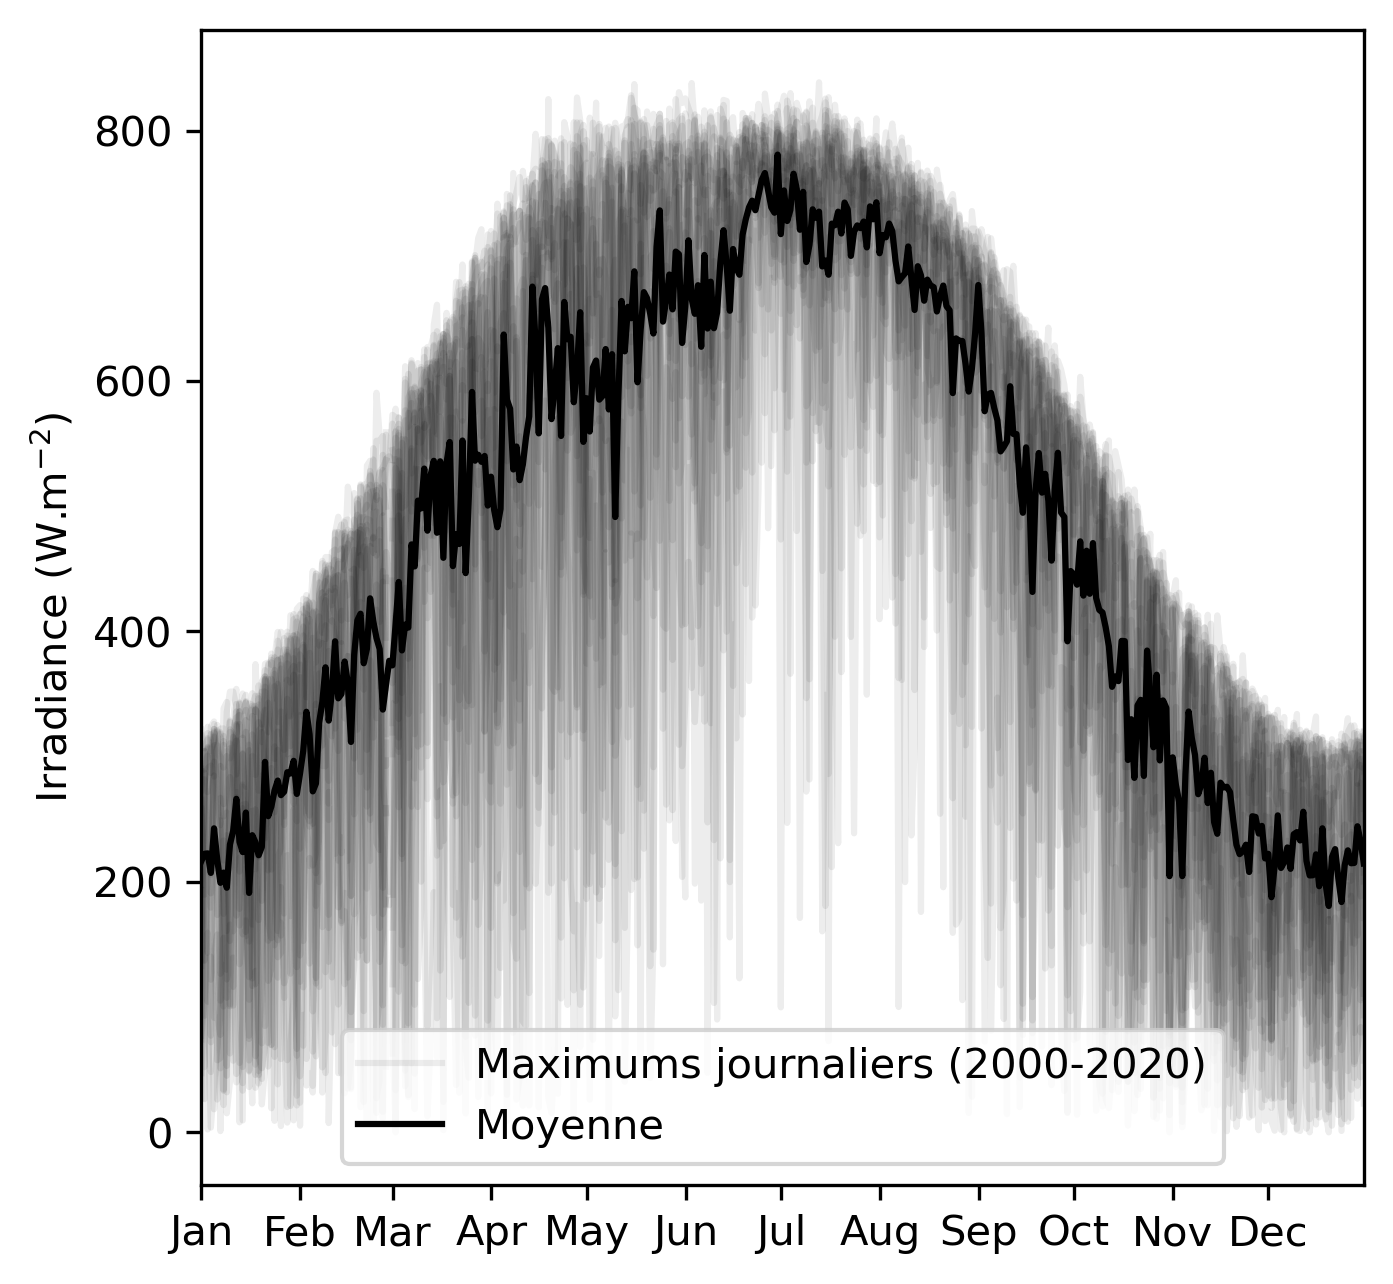

In [15]:
if True:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Maximums journaliers ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_solar_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_solar_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

Modélisation de l'irradiance solaire à partir des équations astronomiques, incluses dans le module pysolar

In [16]:
from pysolar.solar import get_azimuth, get_altitude

month_day_hourly_solar_data['altitude'] = [get_altitude(latitude, longitude, d) if d is not pd.NaT else np.nan for d in month_day_hourly_solar_data.index]
month_day_hourly_solar_data['solar_zenith_angle'] = 90-month_day_hourly_solar_data.altitude
month_day_hourly_solar_data['model_irradiance'] = 1361*np.cos(np.deg2rad(month_day_hourly_solar_data.solar_zenith_angle))
month_day_hourly_solar_data[month_day_hourly_solar_data.model_irradiance < 0] = 0

In [17]:
#hour_hourly_solar_data = pd.DataFrame(month_day_hourly_solar_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
month_day_hourly_solar_data['hour'] = month_day_hourly_solar_data.index.hour
month_day_hourly_solar_data['day'] = month_day_hourly_solar_data.index.day
month_day_hourly_solar_data['month'] = month_day_hourly_solar_data.index.month

solar_correcter_dict = dict()
for year in range(2000,2021):
    for month in range(1,13):
        hour_hourly_solar_data = month_day_hourly_solar_data[month_day_hourly_solar_data.month==month].copy()
        hour_hourly_solar_data = hour_hourly_solar_data.groupby(by='hour').mean().reset_index()
        
        mean = hour_hourly_solar_data[[year]].mean(axis=1)
        model = hour_hourly_solar_data.model_irradiance
        correcter = model.max()/mean.max()
        model = model/correcter
        corr = r2_score(mean, model)
    
        solar_correcter_dict[pd.to_datetime('{}-{}-01'.format(year,month))] = correcter
    
if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = month_day_hourly_solar_data[month_day_hourly_solar_data.month==month].copy()
        plot_hour_hourly_data = plot_hour_hourly_data.groupby(by='hour').mean().reset_index()
        
        mean = plot_hour_hourly_data[list(range(2000,2021))].mean(axis=1)
        model = plot_hour_hourly_data.model_irradiance
        correcter = model.max()/mean.max()
        model = model/correcter
        corr = r2_score(mean, model)
        
        if month in [1,4,7,10]:#list(range(1,13)):,
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour, mean ,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    ax.set_xlabel('Heure de la journée (h)')
    ax.set_ylabel('Irradiation solaire (W.m$^{-2}$)')
    
    plt.savefig(os.path.join(figs_folder,'daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

solar_correcter_df = pd.DataFrame().from_dict({'date':list(solar_correcter_dict.keys()),'correcter':list(solar_correcter_dict.values())}).set_index('date')
solar_correcter_df['month'] = solar_correcter_df.index.month
solar_month_correcter = solar_correcter_df.groupby(by='month').agg(['mean','std']).rename(columns={'mean':'mean_value','std':'std_value'})
solar_month_correcter.columns = solar_month_correcter.columns.droplevel(0)

#popt, _ = curve_fit(lambda x,A,Phi,B: B+A*np.sin(2*np.pi/12*x+Phi), solar_correcter_df.month, solar_correcter_df.correcter, p0=(3,3,3))
#solar_month_correcter['smooth_correcter'] = [popt[2]+popt[0]*np.sin(2*np.pi/12*m+popt[1]) for m in solar_month_correcter.index]

deg = 0
poly_coefs = np.polyfit(solar_month_correcter.index, solar_month_correcter.mean_value, deg=deg)
solar_month_correcter['smooth_correcter'] = [sum([poly_coefs[i]*m**(deg-i) for i in range(deg+1)]) for m in solar_month_correcter.index]

smooth_solar_correcter_dict = {k:v for k,v in zip(solar_month_correcter.index, solar_month_correcter.smooth_correcter)}

if False:
    fig,ax = plt.subplots(dpi=300, figsize=(5,5))
    ax.errorbar(solar_month_correcter.index, solar_month_correcter.mean_value,yerr=solar_month_correcter.std_value,label='Corrections brutes',color='k',ls='',marker='o',capsize=2)
    ax.plot(solar_month_correcter.index, solar_month_correcter.smooth_correcter)
    #ax.plot(list(range(1,13)), [a*x**2+b*x+c for x in range(1,13)], label='Corrections lissées', color='tab:blue')
    ax.set_ylabel('Facteur correctif (sans unité)')
    ax.set_xlim([0.9,12.1])
    #ax.set_xlabel("Mois de l'année")
    ax.legend()
    plt.savefig(os.path.join(figs_folder,'daily_solar_irradiance_facteur_correctif.png'),bbox_inches='tight')
    plt.show()

smooth_solar_correcter_dict

{1: 2.2220061753842835,
 2: 2.2220061753842835,
 3: 2.2220061753842835,
 4: 2.2220061753842835,
 5: 2.2220061753842835,
 6: 2.2220061753842835,
 7: 2.2220061753842835,
 8: 2.2220061753842835,
 9: 2.2220061753842835,
 10: 2.2220061753842835,
 11: 2.2220061753842835,
 12: 2.2220061753842835}

In [18]:
month_day_hourly_solar_data['model_irradiance_corrected'] = [i/smooth_solar_correcter_dict.get(m) for i,m in zip(month_day_hourly_solar_data.model_irradiance, month_day_hourly_solar_data.index.month)]

if False:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    # for i,y in enumerate(years):
    #     label = None
    #     if i==0:
    #         label='Moyennes journalières ({}-{})'.format(years[0],years[-1])
    #     ax.plot(month_day_daily_solar_data[y],color='k',alpha=0.07, label=label)
    mean_plot = month_day_daily_solar_data[list(range(2000,2021))].mean(axis=1)
    std_plot = month_day_daily_solar_data[list(range(2000,2021))].std(axis=1)
    ax.fill_between(mean_plot.index, mean_plot+std_plot, mean_plot-std_plot,color='lightgrey')
    ax.plot(month_day_daily_solar_data[list(range(2000,2021))].mean(axis=1),label='Moyenne',color='k')
    ax.plot(month_day_daily_solar_data.model_irradiance_corrected,label='Modélisation',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'mean_modelled_daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

## Résolution des modèles RC

### Modèle 1 : R1C1

Initialisation du tableau

In [19]:
X_R1C1 = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
X_R1C1.index = X_R1C1.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
X_R1C1 = X_R1C1[X_R1C1.index.year==2000]

Définition des constantes

In [20]:
R = 1.8e-3 # K/W # à rafiner etc
#R = R/2

Phi_i = 400 # W # apports internes
Aw = 4 # m2 # surface vitrée par logement
T_i = 26 #°C

X_R1C1['R'] = [R]*len(X_R1C1)
X_R1C1['Phi_i'] = [Phi_i]*len(X_R1C1)
X_R1C1['T_i'] = [T_i]*len(X_R1C1)

Ajout des variables météo

In [21]:
meteo_obs_year = 2020
X_R1C1['T_a'] = month_day_hourly_data[meteo_obs_year]
X_R1C1['Phi_s'] = month_day_hourly_solar_data[meteo_obs_year]*Aw

#### Résolution

In [22]:
X_R1C1['T_e'] = (X_R1C1['T_a'] + X_R1C1['T_i'])/2 
X_R1C1['Phi_e'] = -1/X_R1C1['R']*X_R1C1['T_e'] + 1/X_R1C1['R']*X_R1C1['T_i'] - X_R1C1['Phi_i'] - X_R1C1['Phi_s']

X_R1C1['Phi_e_warming'] = X_R1C1[X_R1C1.Phi_e > 0].Phi_e
X_R1C1['Phi_e_cooling'] = X_R1C1[X_R1C1.Phi_e < 0].Phi_e

X_R1C1['Phi_e_cooling'] = - X_R1C1['Phi_e_cooling']
X_R1C1['Phi_e_cooling'] = X_R1C1[~X_R1C1.T_a.isna()]['Phi_e_cooling'].fillna(0)
X_R1C1['Phi_e_warming'] = X_R1C1[~X_R1C1.T_a.isna()]['Phi_e_warming'].fillna(0)

monthly_consumptions_R1C1 = X_R1C1[['Phi_e_cooling','Phi_e_warming']].groupby(pd.Grouper(freq='MS')).sum()/1000
monthly_consumptions_R1C1.index = monthly_consumptions_R1C1.index.strftime('%B')
monthly_consumptions_R1C1

,Phi_e_cooling,Phi_e_warming
January,0.000000,2789.734622
February,0.272311,2312.891867
March,3.261911,2356.146800
April,69.206444,1654.756756
May,288.198178,976.735556
June,467.507733,596.246133
July,923.442933,229.347644
August,864.220089,224.433244
September,364.507378,648.255867
October,13.655467,1605.182000


In [23]:
monthly_consumptions_R1C1.Phi_e_warming.sum()

np.float64(18317.33382222222)

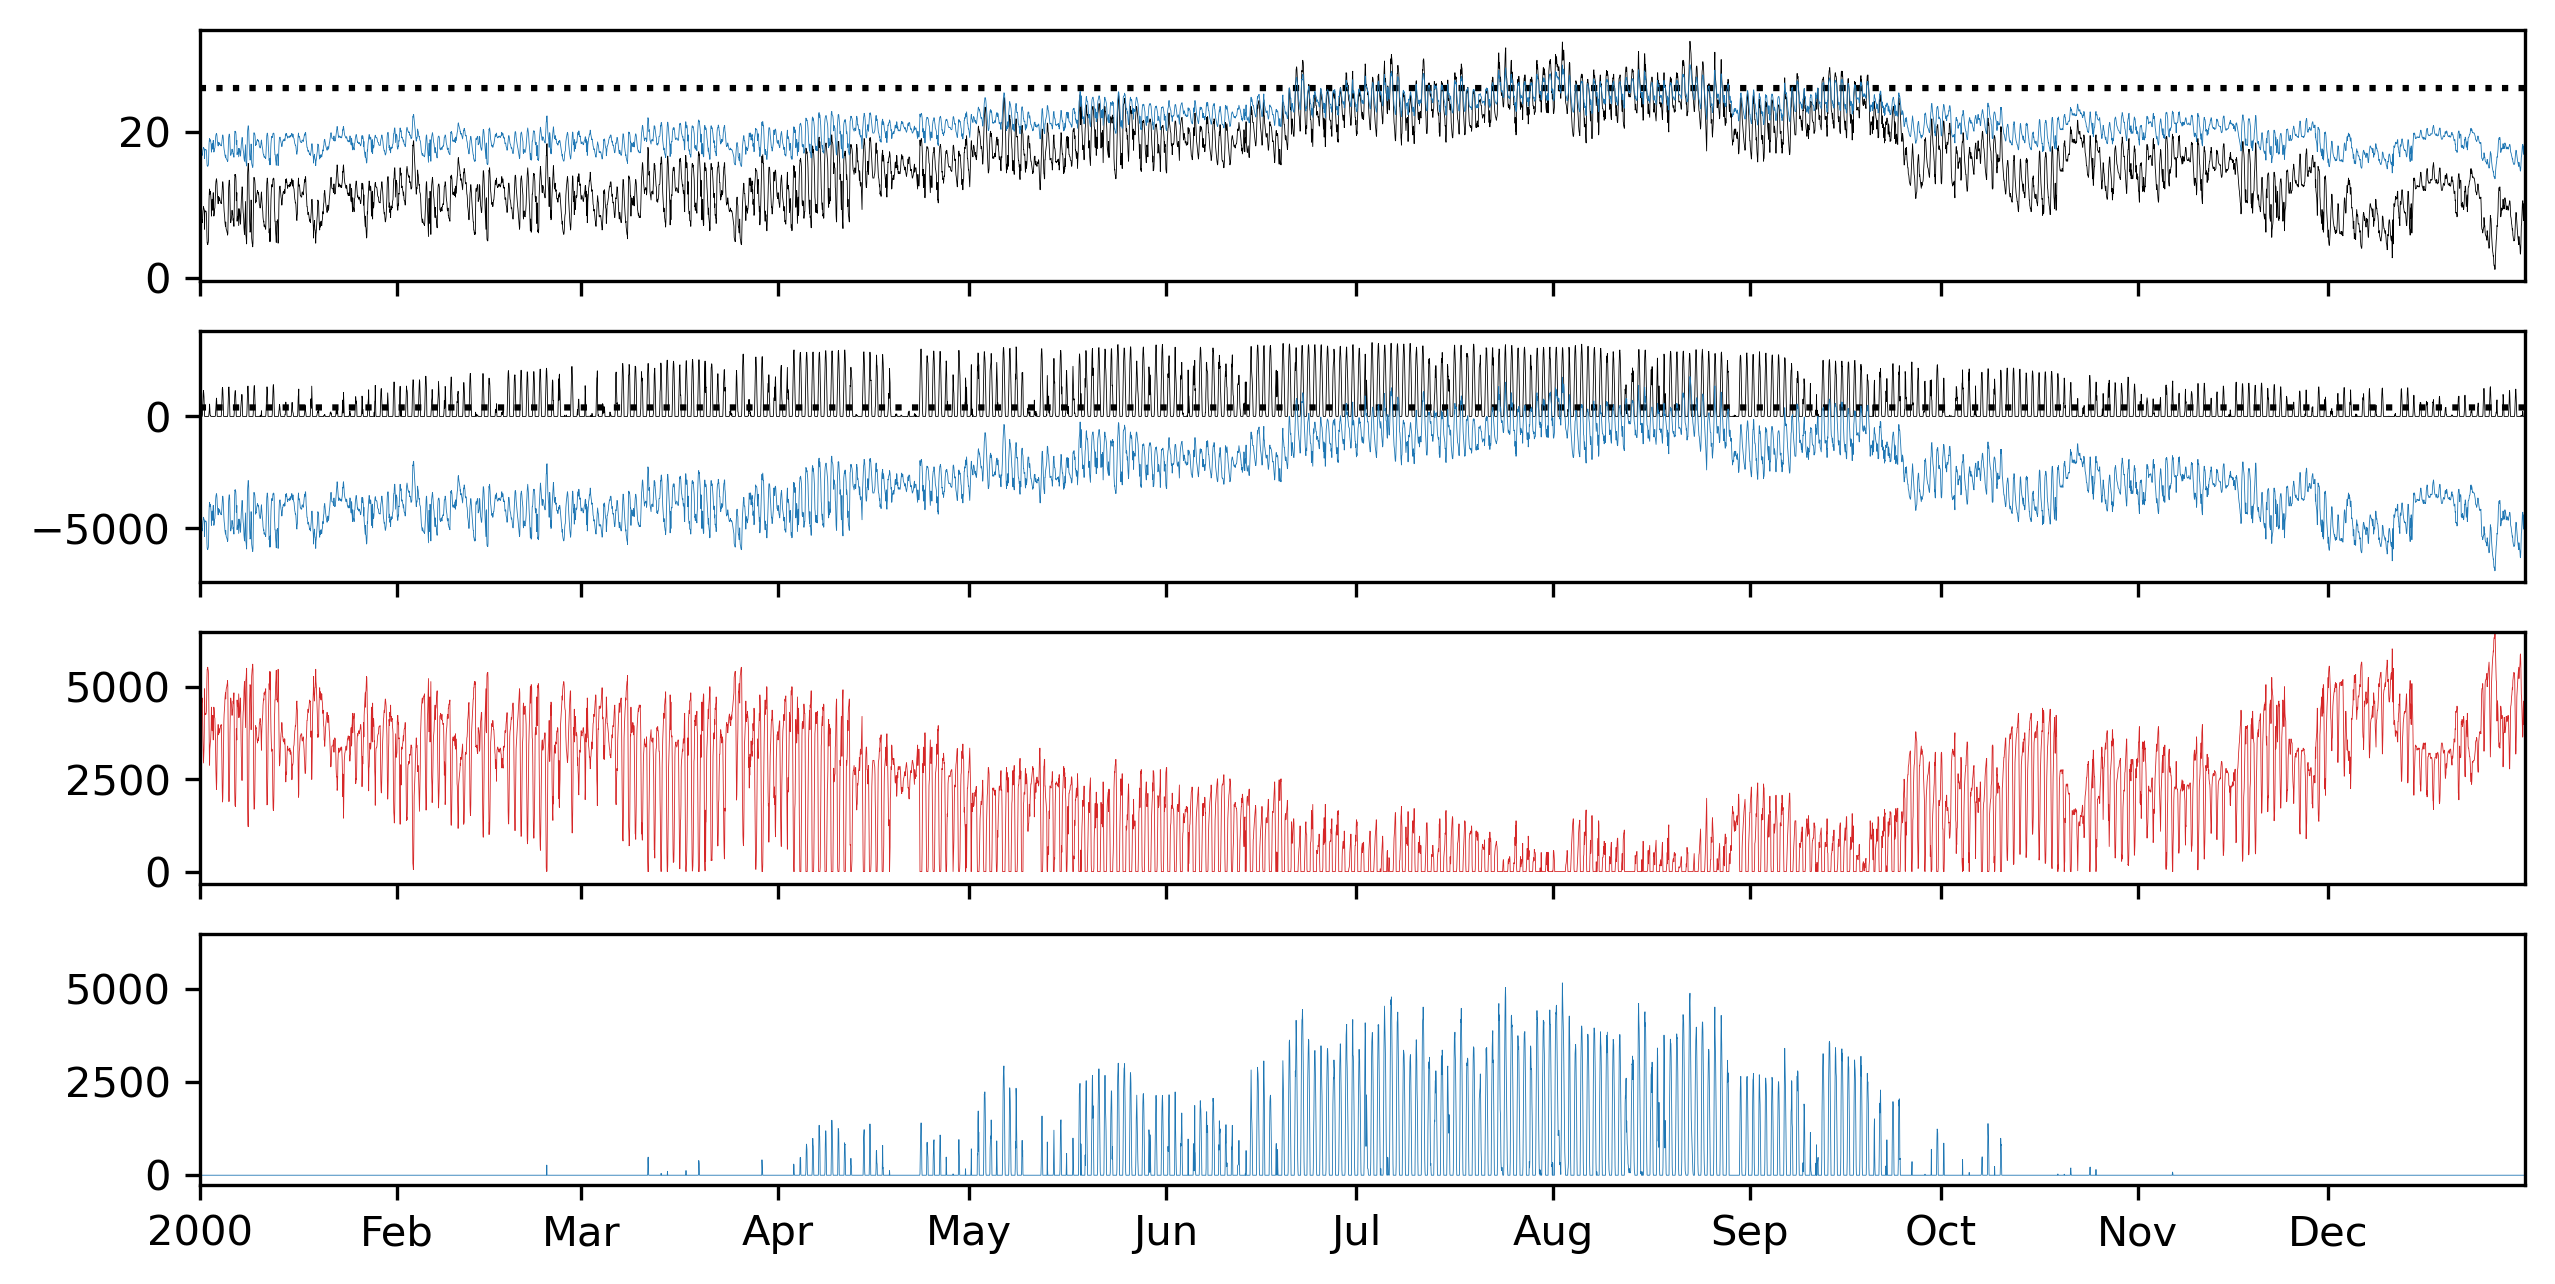

In [24]:
fig,axs = plt.subplots(4,1,dpi=300,figsize=(10,5),sharex=True)
axs = axs.flatten()

date_range = [pd.to_datetime('2000-01-01 00:00:00'), pd.to_datetime('2000-12-31 23:59:59')]

axs[0].plot(X_R1C1['T_a'],lw=0.2, label='External temperature (°C)',color='k')
axs[0].plot(X_R1C1['T_i'], label='Internal setpoint temperature (°C)',color='k',ls=':')
axs[0].plot(X_R1C1['T_e'], label='Mid-wall temperature (°C)',color='tab:blue',lw=0.2)

axs[1].plot(X_R1C1['Phi_s'],lw=0.2,color='k')
axs[1].plot(X_R1C1['Phi_i'],color='k',ls=':')
axs[1].plot(1/X_R1C1['R']*X_R1C1['T_e'] - 1/X_R1C1['R']*X_R1C1['T_i'],lw=0.2,color='tab:blue')


axs[2].plot(X_R1C1['Phi_e_warming'],lw=0.2,color='tab:red')
axs[2].set_ylim(top=max(abs(X_R1C1.Phi_e)))

axs[3].plot(X_R1C1['Phi_e_cooling'],lw=0.2,color='tab:blue')
axs[3].set_ylim(top=max(abs(X_R1C1.Phi_e)))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.DateFormatter('%b')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].set_xlim(date_range)
#axs[0].legend()

plt.show()

## Modèle 2 : R2C2

In [25]:
X_R2C2 = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
X_R2C2.index = X_R2C2.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
X_R2C2 = X_R2C2[X_R2C2.index.year==2000]

R = 1.8e-3 # K/W # à rafiner etc
#R = R/2
C = 8.1e7/3600 # J/K # idem

Phi_i = 400 # W # apports internes
Aw = 4 # m2 # surface vitrée par logement
T_i = T_i #°C

X_R2C2['C'] = [C]*len(X_R2C2)
X_R2C2['R'] = [R]*len(X_R2C2)
X_R2C2['Phi_i'] = [Phi_i]*len(X_R2C2)
X_R2C2['T_i'] = [T_i]*len(X_R2C2)
X_R2C2['Phi_e'] = [0]*len(X_R2C2)

X_R2C2['T_a'] = month_day_hourly_data[meteo_obs_year]
X_R2C2['Phi_s'] = month_day_hourly_solar_data[meteo_obs_year]*Aw
X_R2C2 = X_R2C2.interpolate()

#### Résolution

In [26]:
from scipy.integrate import odeint

def X(t):
    R1, R2 = R, R
    C1 = C
    Ti = T_i
    idx_down = min(int(t//1), len(X_R2C2)-1)
    pond_up = t%1
    idx_up = min(idx_down+1, len(X_R2C2)-1)
    Ta = X_R2C2.iloc[idx_down]['T_a']*(1-pond_up) + X_R2C2.iloc[idx_up]['T_a']*pond_up
    return R1,R2,C1,Ti,Ta

def dTe_dt(Te, t, pbar, state):
    last_t, dt = state
    n = int((t - last_t)/dt)
    pbar.update(n)
    state[0] = last_t + dt * n
    
    R1,R2,C,Ti,Ta = X(t)
    dTe_dt = (-(1)/(R1*C)-(1)/(R2*C))*Te + 1/(R2*C)*Ti + 1/(R1*C)*Ta
    return dTe_dt

Te0 = (X_R2C2.iloc[0]['T_a'] + T_i)/2
delta_t = 0.05
t = np.arange(0.0, len(X_R2C2), delta_t)

with tqdm.tqdm(total=len(X_R2C2)) as pbar:
    state = [0, 1]
    Te = odeint(dTe_dt, Te0, t, args=(pbar,state))

int_idxs = [i for i,e in enumerate(t) if int(e) == e]
X_R2C2['T_e'] = Te.T[0][int_idxs]
X_R2C2['Phi_e'] = -1/X_R2C2['R']*X_R2C2['T_e'] + 1/X_R2C2['R']*X_R2C2['T_i'] - X_R2C2['Phi_i'] - X_R2C2['Phi_s']

X_R2C2['Phi_e_warming'] = X_R2C2[X_R2C2.Phi_e > 0].Phi_e
X_R2C2['Phi_e_cooling'] = X_R2C2[X_R2C2.Phi_e < 0].Phi_e

X_R2C2['Phi_e_cooling'] = - X_R2C2['Phi_e_cooling']
X_R2C2['Phi_e_cooling'] = X_R2C2[~X_R2C2.T_a.isna()]['Phi_e_cooling'].fillna(0)
X_R2C2['Phi_e_warming'] = X_R2C2[~X_R2C2.T_a.isna()]['Phi_e_warming'].fillna(0)

monthly_consumptions_R2C2 = X_R2C2[['Phi_e_cooling','Phi_e_warming']].groupby(pd.Grouper(freq='MS')).sum()/1000
monthly_consumptions_R2C2.index = monthly_consumptions_R2C2.index.strftime('%B')
monthly_consumptions_R2C2 = pd.concat([monthly_consumptions_R2C2,pd.DataFrame().from_dict({'Total':['Total'],
                                                                                           'Phi_e_cooling':[monthly_consumptions_R2C2.Phi_e_cooling.sum()],
                                                                                           'Phi_e_warming':[monthly_consumptions_R2C2.Phi_e_warming.sum()]}).set_index('Total')])
monthly_consumptions_R2C2

100%|██████████████████████████████████████| 8782/8782 [00:14<00:00, 622.76it/s]


,Phi_e_cooling,Phi_e_warming
January,0.000000,2818.306942
February,0.000000,2313.074822
March,0.000000,2355.088701
April,4.310865,1612.860718
May,143.418245,846.811777
June,311.903921,469.114808
July,736.331603,56.541092
August,719.387801,51.232205
September,213.213927,475.625188
October,0.121634,1579.042607


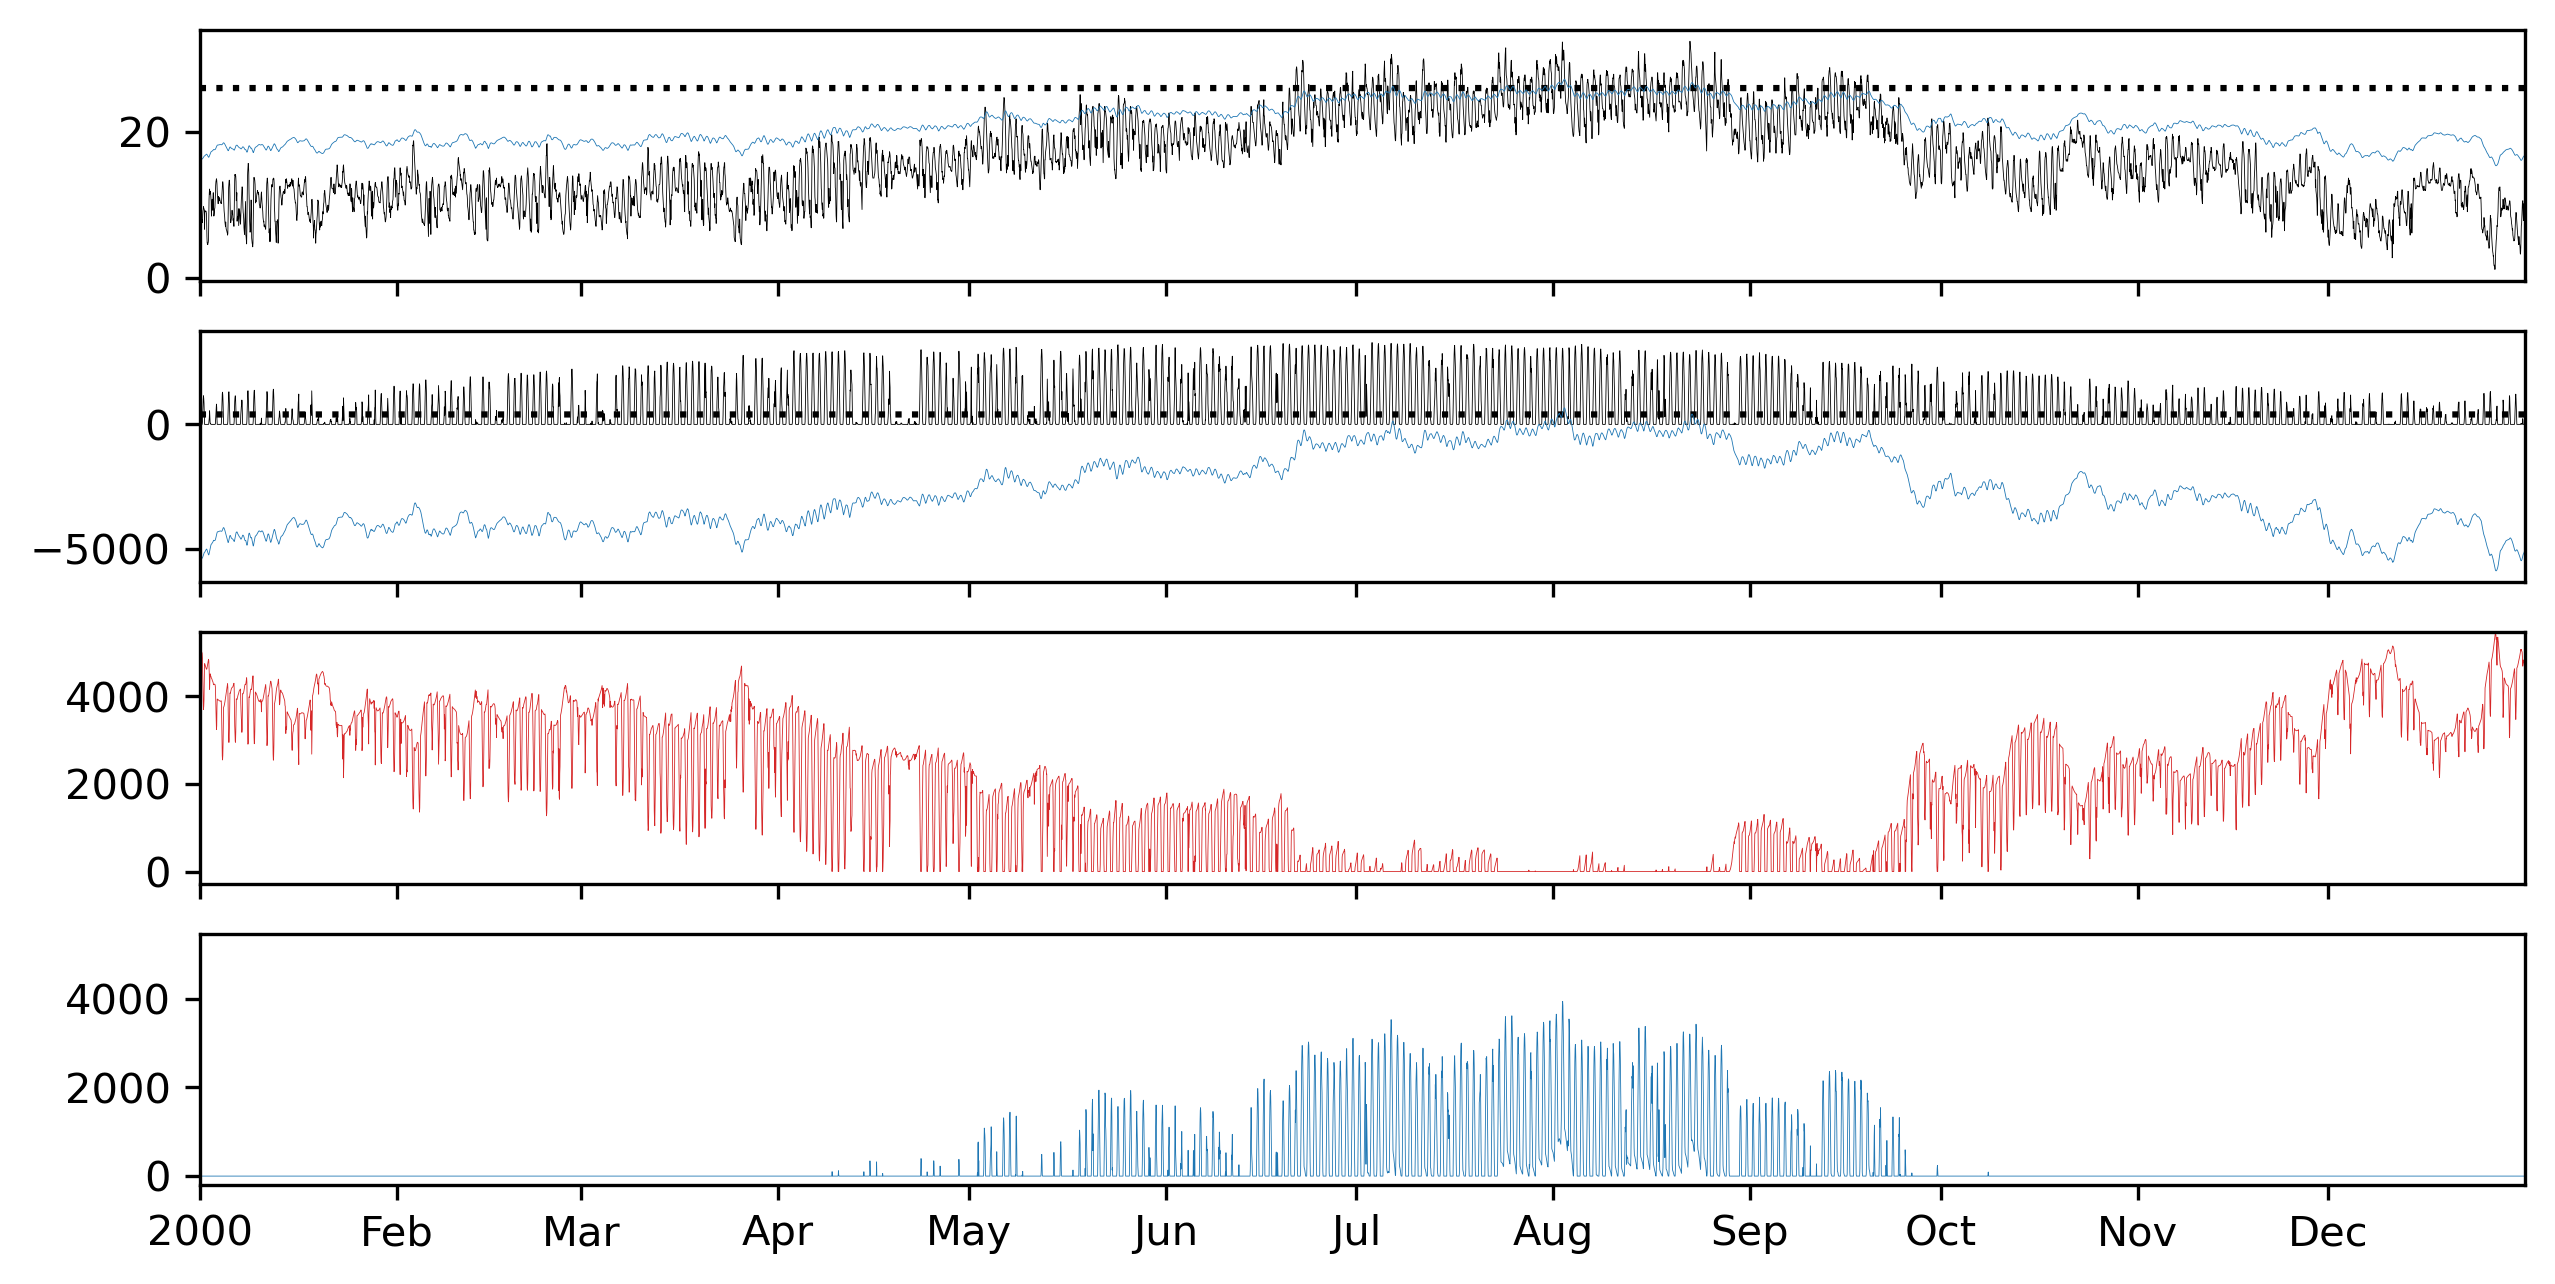

In [27]:
fig,axs = plt.subplots(4,1,dpi=300,figsize=(10,5),sharex=True)
axs = axs.flatten()

date_range = [pd.to_datetime('2000-01-01 00:00:00'), pd.to_datetime('2000-12-31 23:59:59')]

axs[0].plot(X_R2C2['T_a'],lw=0.2, label='External temperature (°C)',color='k')
axs[0].plot(X_R2C2['T_i'], label='Internal setpoint temperature (°C)',color='k',ls=':')
axs[0].plot(X_R2C2['T_e'], label='Mid-wall temperature (°C)',color='tab:blue',lw=0.2)

axs[1].plot(X_R2C2['Phi_s'],lw=0.2,color='k')
axs[1].plot(X_R2C2['Phi_i'],color='k',ls=':')
axs[1].plot(1/X_R2C2['R']*X_R2C2['T_e'] - 1/X_R2C2['R']*X_R2C2['T_i'],lw=0.2,color='tab:blue')

axs[2].plot(X_R2C2['Phi_e_warming'],lw=0.2,color='tab:red')
axs[2].set_ylim(top=max(abs(X_R2C2.Phi_e)))

axs[3].plot(X_R2C2['Phi_e_cooling'],lw=0.2,color='tab:blue')
axs[3].set_ylim(top=max(abs(X_R2C2.Phi_e)))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.DateFormatter('%b')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].set_xlim(date_range)
#axs[0].legend()

plt.show()

In [28]:
from matplotlib.collections import LineCollection
from matplotlib.ticker import FuncFormatter

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    lines = colored_line(X_R2C2['T_a'],X_R2C2['T_e'], np.linspace(0, 1, len(X_R2C2)), ax, lw=0.5, cmap="viridis")
    
    fmt = lambda x, pos: (pd.Timedelta(1, "h") + pd.to_datetime(X_R2C2.index.values[int(x*(len(X_R2C2)-1))])).strftime('%b')
    cbar = fig.colorbar(lines,format=FuncFormatter(fmt))
    
    min_Ta, max_Ta = X_R2C2['T_a'].min(), X_R2C2['T_a'].max()
    ax.set_xlim([min_Ta, max_Ta])
    ax.set_ylim([min_Ta, max_Ta])

## Comparaison entre les modèles

In [29]:
diff = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
diff.index = diff.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
diff = diff[diff.index.year==2000]

diff['Phi_e_warming_R1C1'] = X_R1C1['Phi_e_warming']
diff['Phi_e_warming_R2C2'] = X_R2C2['Phi_e_warming']
diff['Delta_Phi_e_warming'] = diff.Phi_e_warming_R1C1 - diff.Phi_e_warming_R2C2

diff['Phi_e_cooling_R1C1'] = X_R1C1['Phi_e_cooling']
diff['Phi_e_cooling_R2C2'] = X_R2C2['Phi_e_cooling']
diff['Delta_Phi_e_cooling'] = diff.Phi_e_cooling_R1C1 - diff.Phi_e_cooling_R2C2

diff['T_a'] = X_R1C1['T_a']
diff['T_e_R1C1'] = X_R1C1['T_e']
diff['T_e_R2C2'] = X_R2C2['T_e']

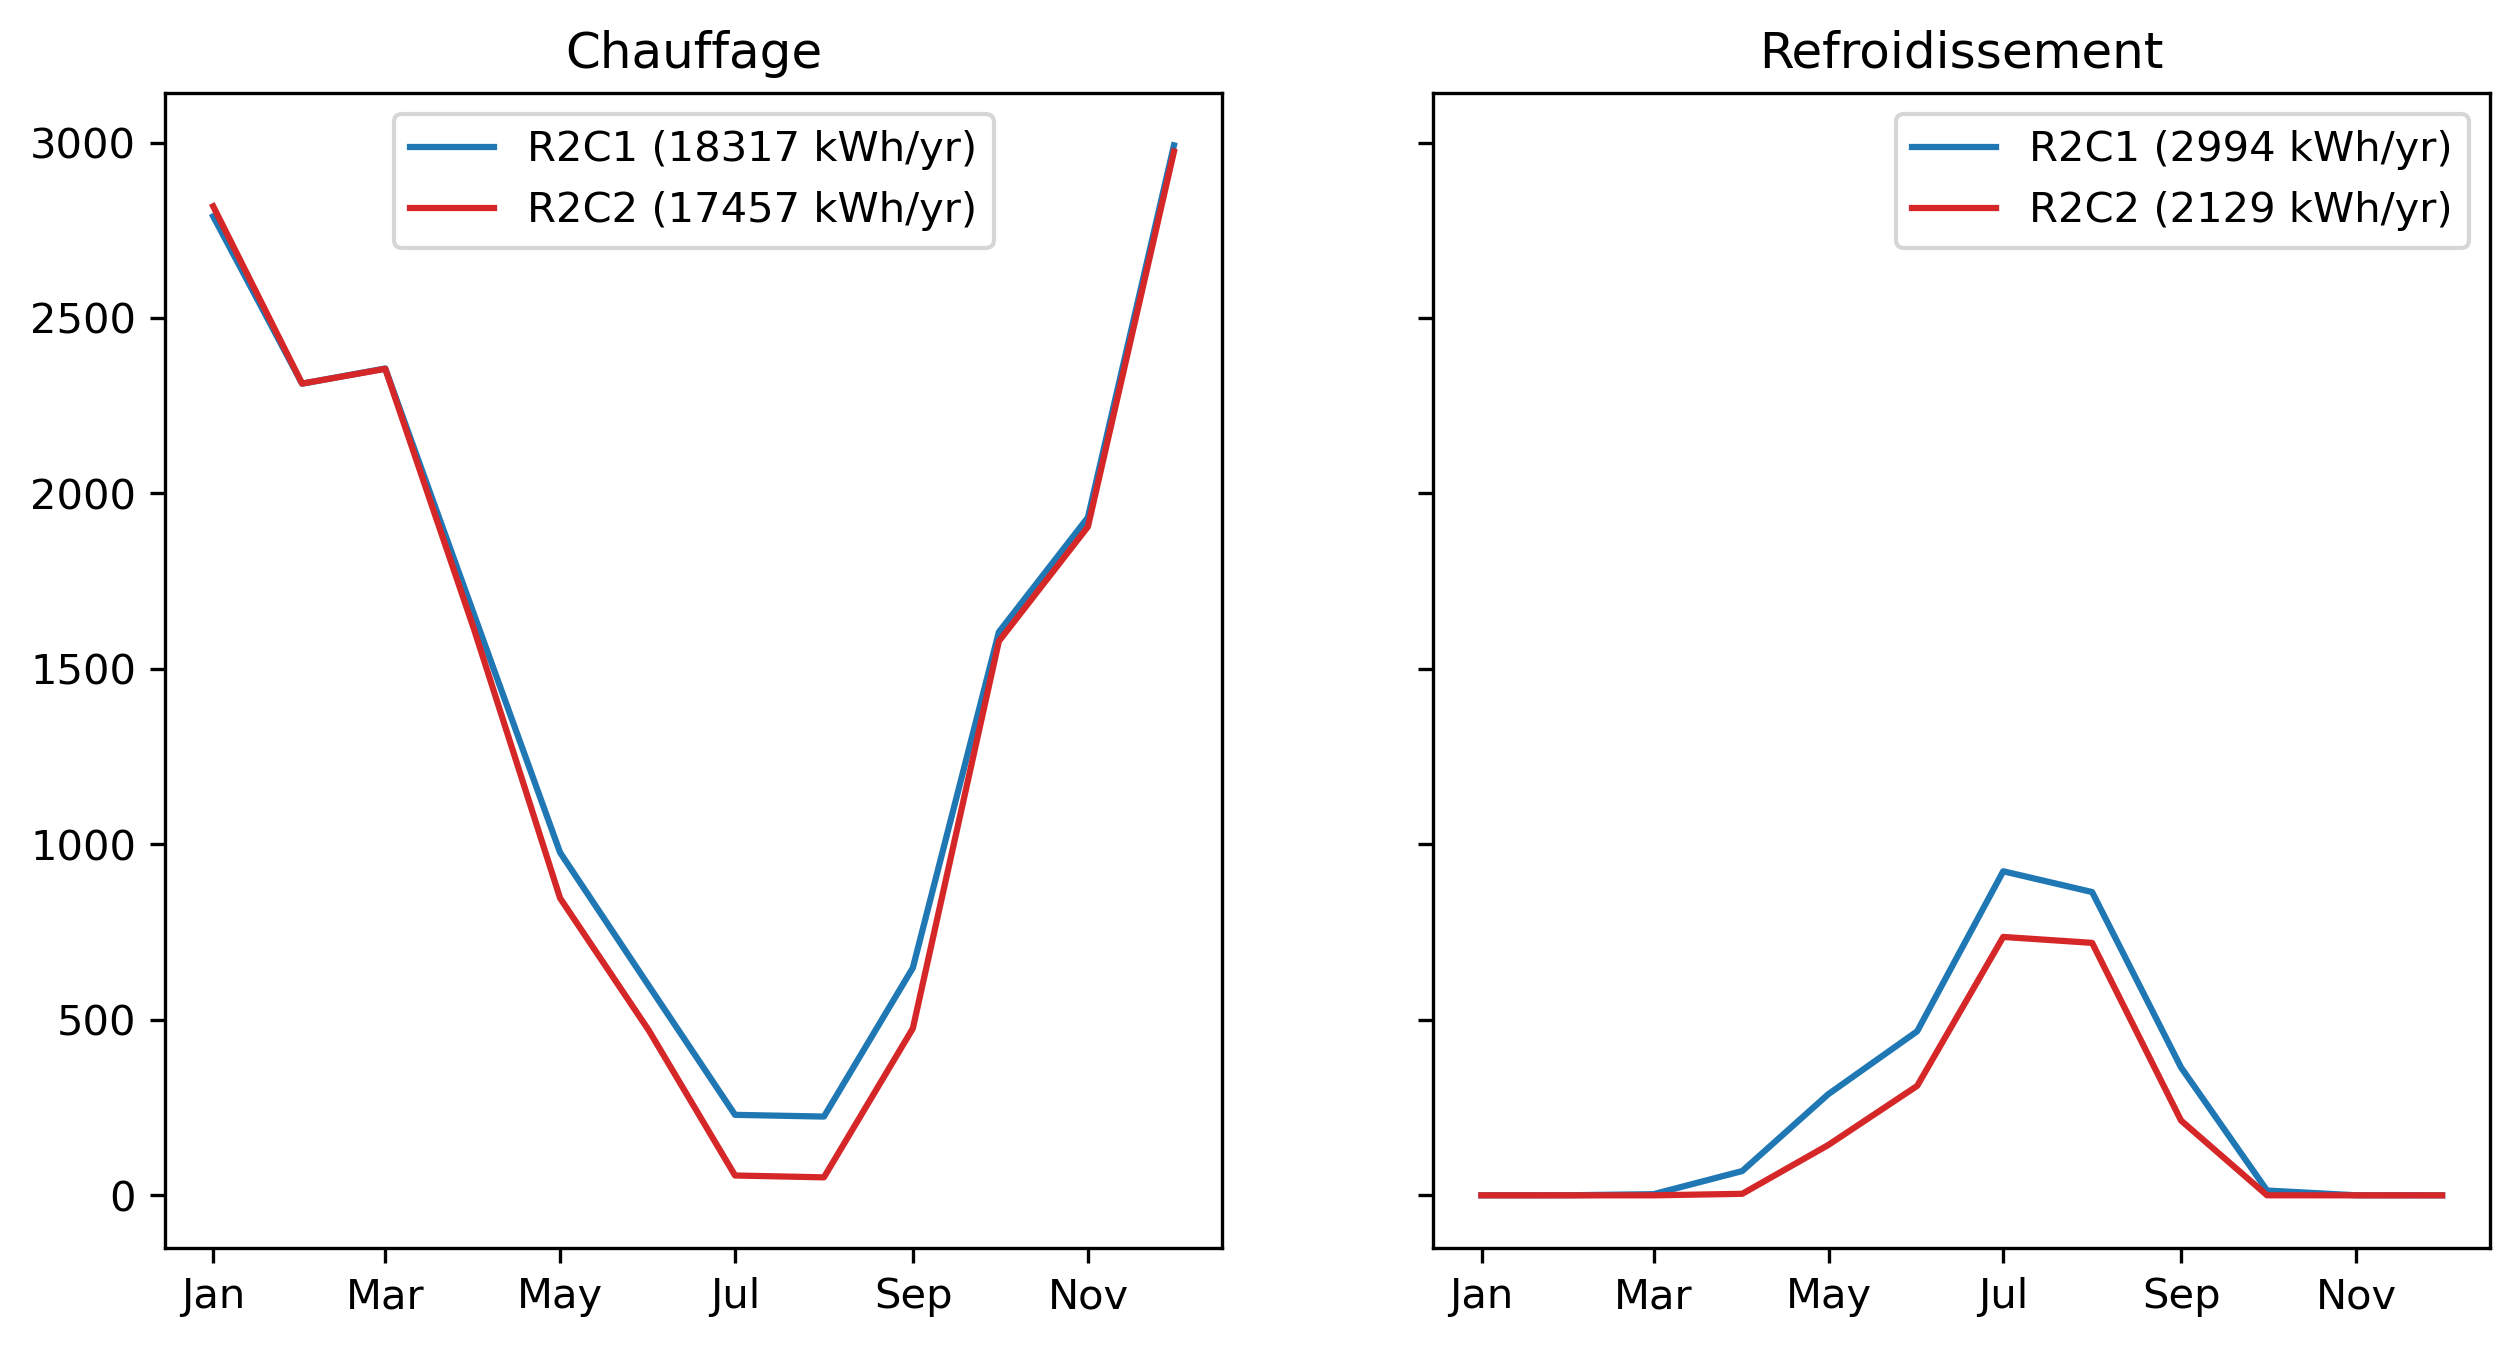

In [30]:
fig,axs = plt.subplots(1,2,dpi=300,figsize=(10,5),sharex=True, sharey=True)
axs = axs.flatten()

axs[0].plot(diff.Phi_e_warming_R1C1.groupby(pd.Grouper(freq='MS')).sum()/1000,label='R2C1 ({:.0f} kWh/yr)'.format(diff.Phi_e_warming_R1C1.sum()/1000),color='tab:blue')
axs[0].plot(diff.Phi_e_warming_R2C2.groupby(pd.Grouper(freq='MS')).sum()/1000,label='R2C2 ({:.0f} kWh/yr)'.format(diff.Phi_e_warming_R2C2.sum()/1000),color='tab:red')
#axs[0].plot(diff.Phi_e_warming_R1C1.groupby(pd.Grouper(freq='MS')).sum()/1000 - diff.Phi_e_warming_R2C2.groupby(pd.Grouper(freq='MS')).sum()/1000,label='diff',color='k')
axs[0].set_title('Chauffage')
axs[0].legend()

axs[1].plot(diff.Phi_e_cooling_R1C1.groupby(pd.Grouper(freq='MS')).sum()/1000,label='R2C1 ({:.0f} kWh/yr)'.format(diff.Phi_e_cooling_R1C1.sum()/1000),color='tab:blue')
axs[1].plot(diff.Phi_e_cooling_R2C2.groupby(pd.Grouper(freq='MS')).sum()/1000,label='R2C2 ({:.0f} kWh/yr)'.format(diff.Phi_e_cooling_R2C2.sum()/1000),color='tab:red')
#axs[1].plot(diff.Phi_e_cooling_R1C1.groupby(pd.Grouper(freq='MS')).sum()/1000 - diff.Phi_e_cooling_R2C2.groupby(pd.Grouper(freq='MS')).sum()/1000,label='diff',color='k')
axs[1].set_title('Refroidissement')
axs[1].legend()

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
formatter = mdates.DateFormatter('%b')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

#plt.savefig(os.path.join(figs_folder,'test3.png'),bbox_inches='tight')
plt.show()

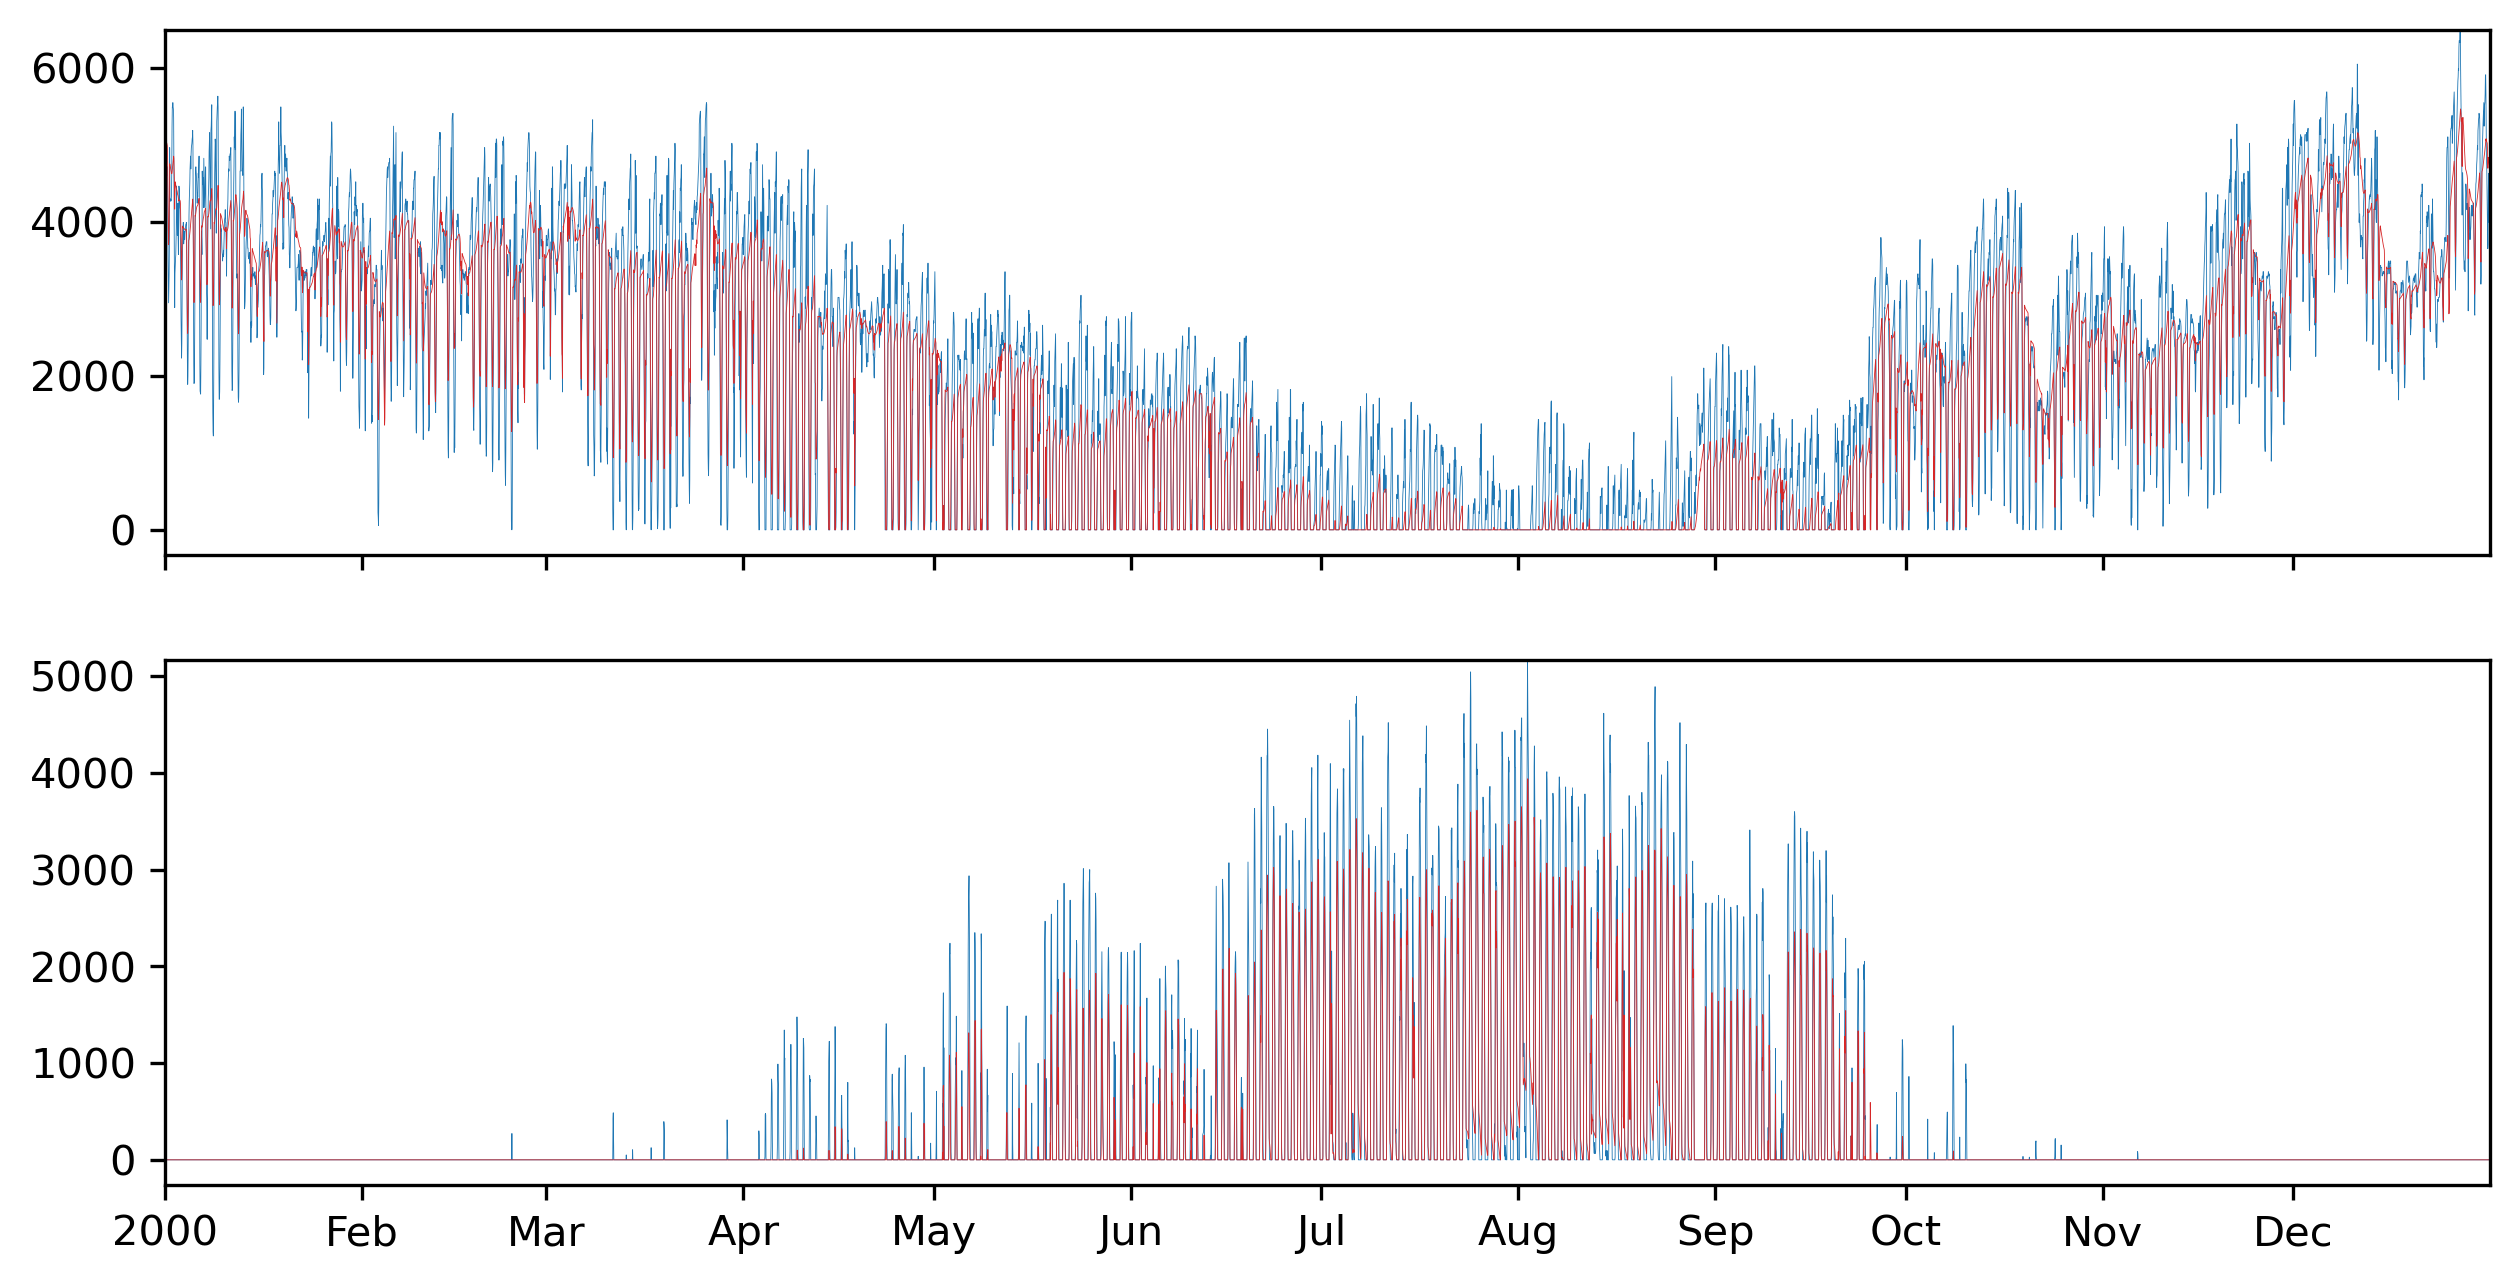

In [31]:
fig,axs = plt.subplots(2,1,dpi=300,figsize=(10,5),sharex=True)
axs = axs.flatten()

date_range = [pd.to_datetime('2000-01-01 00:00:00'), pd.to_datetime('2000-12-31 23:59:59')]

axs[0].plot(diff['Phi_e_warming_R1C1'],lw=0.2,color='tab:blue')
axs[0].plot(diff['Phi_e_warming_R2C2'],lw=0.2,color='tab:red')
#axs[0].plot((diff['Phi_e_warming_R1C1'] - diff['Phi_e_warming_R2C2']),lw=0.2,color='k')
axs[0].set_ylim(top=max(abs(diff.Phi_e_warming_R1C1)))

axs[1].plot(diff['Phi_e_cooling_R1C1'],lw=0.2,color='tab:blue')
axs[1].plot(diff['Phi_e_cooling_R2C2'],lw=0.2,color='tab:red')
#ax1b = axs[1].twinx()
#ax1b.plot((diff['Phi_e_cooling_R1C1'] - diff['Phi_e_cooling_R2C2']),lw=0.2,color='k')
axs[1].set_ylim(top=max(abs(diff.Phi_e_cooling_R1C1)))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.DateFormatter('%b')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].set_xlim(date_range)
#axs[0].legend()

plt.show()

In [32]:
if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    lines = colored_line(diff['T_e_R1C1'],diff['T_e_R2C2'], np.linspace(0, 1, len(X_R2C2)), ax, lw=0.5, cmap="viridis")
    
    fmt = lambda x, pos: (pd.Timedelta(1, "h") + pd.to_datetime(diff.index.values[int(x*(len(diff)-1))])).strftime('%b')
    cbar = fig.colorbar(lines,format=FuncFormatter(fmt))
    
    min_Ta, max_Ta = diff['T_e_R1C1'].min(), diff['T_e_R1C1'].max()
    ax.plot([min_Ta, max_Ta], [min_Ta, max_Ta], color='k')
    ax.set_xlim([min_Ta, max_Ta])
    ax.set_ylim([min_Ta, max_Ta])
    plt.show()

In [33]:
if False:
    fig,ax = plt.subplots(dpi=300,figsize=(10,5),sharex=True, sharey=True)

    ax.plot((diff.T_e_R1C1 - diff.T_a),label='R2C1',color='tab:blue',lw=0.2)
    ax.plot((diff.T_e_R2C2 - diff.T_a),label='R2C2',color='tab:red',lw=0.2,zorder=-1)
    ax.legend()
    
    #ax.plot((diff.T_e_R1C1 - diff.T_a).groupby(pd.Grouper(freq='MS')).std(),label='R2C1',color='tab:blue')
    #ax.plot((diff.T_e_R2C2 - diff.T_a).groupby(pd.Grouper(freq='MS')).std(),label='R2C2',color='tab:red')
    #ax.legend()
    
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    #plt.savefig(os.path.join(figs_folder,'test3.png'),bbox_inches='tight')
    plt.show()